## Imports and Path/Variable Definitions

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import h5py
from scipy import signal
import argparse
import seaborn as sns
from datetime import date
import os
import X_gnss_unet_datagen_fn9 # Module with CNN/data generator code

sns.set_style('white')

project_name = 'july6' # Based on the name of the FakeQuakes project
fq_dir = '/hdd/rc_fq/summer23/' # Where are the FakeQuakes stored? (The final .hdf5 file)
noise_dir = '/home/sdybing/gnss-picker/data/noisedata/' # Where is the noise data stored?

cnn_save_dir = '/home/sdybing/gnss-picker/cnn_models_outputs/' # Where do you want to save this code's outputs?
project_save_dir = cnn_save_dir + project_name + '_fq_train/'
if os.path.isdir(project_save_dir):
    pass
else:
    os.makedirs(project_save_dir)
data_save_dir = project_save_dir + 'data/' # Where to save the outputted testing data and predictions
model_save_dir = project_save_dir + 'models/' # Where to save the trained models
figure_save_dir = project_save_dir + 'figures/' # Where to save the figures

train = 1 # Do you want to train? 0 = no, 1 = yes
drop = 1 # Drop?
resume = 0 # Resume training
large = 0.5 # Large unet
fac = large
epochs = 10 # How many epochs?
std = 3 # How long do you want the Gaussian STD to be?
sr = 1 # Sample rate (Hz)
epsilon = 1e-6
batch_size = 32
load = 0 # Loading an old trained model?

## Data Loading and Formatting

### Load the Data

In [2]:
# FakeQuakes waveform data
print('Loading FakeQuakes...')
fq_data = h5py.File(fq_dir + 'july6_128samps_fq_wvfm_data_formatted.hdf5', 'r')
fq_data = fq_data['data'][:,:]
# print(x_data.shape)

# FakeQuakes metadata
print('Loading FakeQuakes metadata...')
fq_metadata = np.load(fq_dir + 'july6_128samps_fq_wvfm_info.npy')

# Noise data
print('Loading noise...')
all_noise_data = h5py.File(noise_dir + 'summer23_128samps_all_noise_samples.hdf5', 'r')
all_noise_data = all_noise_data['all_noise_samples'][:,:]

# Trim noise data to match length of FakeQuakes data
noise_data = all_noise_data[:len(fq_data)]

# Array of NaNs to use to match added noise in concatenation later
nan_array = np.empty((len(fq_data), 3))
nan_array[:] = np.NaN

# Real data

# Check shapes
print('FakeQuakes shape: ' + str(fq_data.shape))
print('Noise data shape: ' + str(noise_data.shape))

Loading FakeQuakes...
Loading FakeQuakes metadata...
Loading noise...
FakeQuakes shape: (917400, 768)
Noise data shape: (917400, 768)


### Format and Split Training, Validation, and Testing Data

In [4]:
np.random.seed(27)

# Earthquake/signal data
fqinds = np.arange(fq_data.shape[0]) # Signal indices
np.random.shuffle(fqinds) # Shuffles the indices
train_fqinds = fqinds[:int(0.8*len(fqinds))] # Training data separation: grabs the front 80% of the numbers
valid_fqinds = fqinds[int(0.8*len(fqinds)):int(0.9*len(fqinds)):] # Grabs the next 10% (80-90%)
test_fqinds = fqinds[int(0.9*len(fqinds)):] # Grabs the last 10% (90%-end)

# Noise data
noiseinds = np.arange(noise_data.shape[0]) # Noise indices
np.random.shuffle(noiseinds) # Shuffles the indices
train_noiseinds = noiseinds[:int(0.8*len(noiseinds))] # Data separation as above
valid_noiseinds = noiseinds[int(0.8*len(noiseinds)):int(0.9*len(noiseinds))]
test_noiseinds = noiseinds[int(0.9*len(noiseinds)):]

# Check shapes to confirm compatability
print('Full FakeQuakes data shape: ' + str(fqinds.shape))
print('FakeQuakes training data shape: ' + str(train_fqinds.shape))
print('FakeQuakes validation data shape: ' + str(valid_fqinds.shape))
print('FakeQuakes testing data shape: ' + str(test_fqinds.shape))
print('Full noise data shape: ' + str(noiseinds.shape))
print('Noise training data shape: ' + str(train_noiseinds.shape))
print('Noise validation data shape: ' + str(valid_noiseinds.shape))
print('Noise testing data shape: ' + str(test_noiseinds.shape))

Full FakeQuakes data shape: (917400,)
FakeQuakes training data shape: (733920,)
FakeQuakes validation data shape: (91740,)
FakeQuakes testing data shape: (91740,)
Full noise data shape: (917400,)
Noise training data shape: (733920,)
Noise validation data shape: (91740,)
Noise testing data shape: (91740,)


### Check Loaded Data with Plots

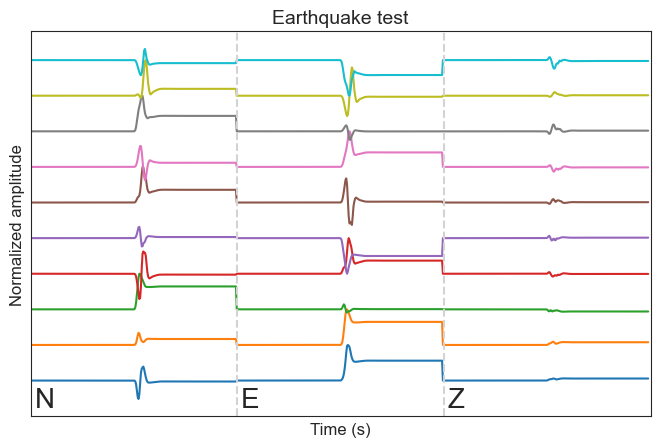

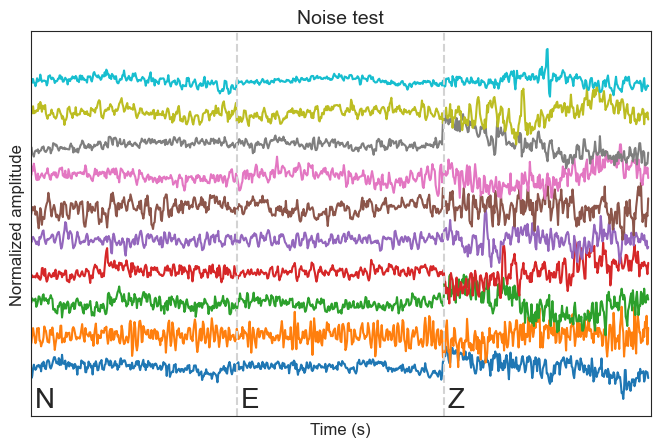

In [5]:
# Plot the FakeQuakes data
plt.figure(figsize = (8,5))   
plt.title('Earthquake test', fontsize = 14)
for idx in range(10): # plot 10 of them
    plt.plot(fq_data[idx,:] / np.max(np.abs(fq_data[idx,:])) + idx) # Normalized and offset for each idx
plt.axvline(256.5, linestyle = '--', color = 'lightgray')
plt.axvline(513.5, linestyle = '--', color = 'lightgray')
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Normalized amplitude', fontsize = 12)
plt.xlim(0,770)
plt.xticks([])
plt.yticks([])
plt.text(x = 5, y = -0.75, s = 'N', fontsize = 20)
plt.text(x = 261, y = -0.75, s = 'E', fontsize = 20)
plt.text(x = 518, y = -0.75, s = 'Z', fontsize = 20)
plt.show()
# plt.savefig(figure_save_dir + '1_plot_raw_eq_data.png', format = 'PNG')
# plt.close()

# Plot noise to check
plt.figure(figsize = (8,5))
plt.title('Noise test', fontsize = 14)
for idx in range(10):
    plt.plot(noise_data[idx,:] / np.max(np.abs(noise_data[idx,:])) + idx)
plt.axvline(256.5, linestyle = '--', color = 'lightgray')
plt.axvline(513.5, linestyle = '--', color = 'lightgray')
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Normalized amplitude', fontsize = 12)
plt.xlim(0,770)
plt.xticks([])
plt.yticks([])
plt.text(x = 5, y = -1.25, s = 'N', fontsize = 20)
plt.text(x = 261, y = -1.25, s = 'E', fontsize = 20)
plt.text(x = 518, y = -1.25, s = 'Z', fontsize = 20)
plt.show()
# plt.savefig(figure_save_dir + '2_plot_noise_data.png', format = 'PNG')
# plt.close()

# Check the PGD distribution

# testing_data = fq_data[test_fqinds]

# pgd = np.zeros(testing_data.shape[0]) # Reminder - FQ data is in meters
# for idx in range(testing_data.shape[0]):
#     pgd[idx] = np.max(np.sqrt((testing_data[idx,:257])**2 + (testing_data[idx,257:514])**2 + (testing_data[idx,514:])**2))

# plt.figure(figsize = (8,5))
# plt.hist(pgd, bins = 30, alpha = 0.5, edgecolor = 'black')
# plt.ylim(0,10000)
# plt.show()
# plt.close()


## Test of Data Generator

In [6]:
checkgen = X_gnss_unet_datagen_fn9.my_3comp_data_generator(32, fq_data, noise_data, fq_metadata, nan_array, train_fqinds, train_noiseinds, sr, std, valid = True) # Valid = True to get original data back
checkgen_data, checkgen_target, checkgen_metadata = next(checkgen) 

print('Data generator check data shape: ' + str(checkgen_data.shape))
print('Data generator check target shape: ' + str(checkgen_target.shape))
print('Data generator check metadata shape: ' + str(checkgen_metadata.shape))

# Shapes:
    # data: (batch_size, 128, 3) # N, E, Z
    # target: (batch_size, 128)
    # metadata: (batch_size, 3) Rupt name, station name, magnitude

# Plot generator results

nexamples = 5 # Number of examples to look at 
  
for ind in range(nexamples): 
    
#     print('Magnitude: ' + str(metadata[ind,2]))

    fig = plt.subplots(nrows = 1, ncols = 3, figsize = (26,4), dpi = 300) # shoter for AGU talk
    plt.subplots_adjust(wspace = 0.4)
    t = 1/sr * np.arange(checkgen_data.shape[1])
    
    ax1 = plt.subplot(131)
    ax1.plot(t, checkgen_data[ind,:,0]*100, label = 'N original data', color = 'C0')
    ax1.set_ylabel('Displacement (cm)')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc = 'upper right')
    ax2 = ax1.twinx()
    ax2.plot(t, checkgen_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax2.set_ylabel('Confidence')
    ax2.legend(loc = 'lower right')
    
    ax3 = plt.subplot(132)
    ax3.plot(t, checkgen_data[ind,:,1]*100, label = 'E original data', color = 'C1')
    ax3.set_ylabel('Displacement (cm)')
    ax3.legend(loc = 'upper right')
    ax4 = ax3.twinx()
    ax4.plot(t, checkgen_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax4.legend(loc = 'lower right')
    
    ax5 = plt.subplot(133)
    ax5.plot(t, checkgen_data[ind,:,2]*100, label = 'Z original data', color = 'C2')
    ax5.set_ylabel('Displacement (cm)')
    ax5.legend(loc = 'upper right')
    ax6 = ax5.twinx()
    ax6.plot(t, checkgen_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax6.legend(loc = 'lower right')
    
#     plt.show()
    plt.savefig(figure_save_dir + '3_ex_' + str(ind) + '_plot_generator_pass.png', format = 'PNG')
    plt.close()


Data generator check data shape: (32, 128, 3)
Data generator check target shape: (32, 128)
Data generator check metadata shape: (32, 3)


## Model Construction

In [7]:
if drop: # Use a model with a dropout layer
    model = X_gnss_unet_datagen_fn9.make_large_unet_drop(fac, sr, ncomps = 3)
    print('Using model with dropout')
else:
    model = X_gnss_unet_datagen_fn9.make_large_unet(fac, sr, ncomps = 3)  
    print('Using large model')

2023-07-26 03:12:09.302104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-26 03:12:09.302175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-07-26 03:12:09.302232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-07-26 03:12:09.302281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-07-26 03:12:09.302328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 128, 16)      1024        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 64, 16)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64, 32)       7712        ['max_pooling1d[0][0]']          
                                                                                              

/home/sdybing/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Train the Model

In [ ]:
if train:
    
    traindate = date.today()
    model_save_file = model_save_dir + 'traindate_' + str(date) + '.tf'
    
    print('Training model and saving results to ' + model_save_file)
        
    csv_logger = tf.keras.callbacks.CSVLogger(model_save_file + '.csv', append = True)
    
    history = model.fit_generator(X_gnss_unet_datagen_fn9.my_3comp_data_generator(batch_size, fq_data, noise_data, fq_metadata, nan_array, train_fqinds, train_noiseinds, sr, std), # Valid = False for training; implied
                        steps_per_epoch = (len(train_fqinds) + len(train_noiseinds))//batch_size,
                        validation_data = X_gnss_unet_datagen_fn9.my_3comp_data_generator(batch_size, fq_data, noise_data, fq_metadata, nan_array, valid_fqinds, valid_noiseinds, sr, std),
                        validation_steps = (len(valid_fqinds) + len(valid_noiseinds))//batch_size,
                        epochs = epochs, callbacks = [csv_logger])
    
    model.save_weights(model_save_file)
    

Training model and saving results to /home/sdybing/gnss-picker/cnn_models_outputs/july6_fq_train/models/traindate_<class 'datetime.date'>.tf
Epoch 1/10
    3/45870 [..............................] - ETA: 20:47 - loss: 0.1309 - accuracy: 0.0000e+00

/tmp/ipykernel_11479/3508639663.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(X_gnss_unet_datagen_fn9.my_3comp_data_generator(batch_size, fq_data, noise_data, fq_metadata, nan_array, train_fqinds, train_noiseinds, sr, std), # Valid = False for training; implied


10589/45870 [=====>........................] - ETA: 15:57 - loss: 0.1244 - accuracy: 0.0089

### Check Training Curves

In [ ]:
training_stats = np.genfromtxt(model_save_file + '.csv', delimiter = ',', skip_header = 1)

fig = plt.subplots(nrows = 2, ncols = 1, figsize = (6,8))
plt.suptitle('Training curves')

ax1 = plt.subplot(211)
ax1.plot(training_stats[1:100,0], training_stats[1:100,1], label = 'Accuracy')
ax1.plot(training_stats[1:100,0], training_stats[1:100,3], label = 'Validation accuracy') 
ax1.legend(loc = 'lower right')
ax1.set_title(model_save_file)

ax2 = plt.subplot(212)
ax2.plot(training_stats[1:100,0], training_stats[1:100,2], label = 'Loss') 
ax2.plot(training_stats[1:100,0], training_stats[1:100,4], label = 'Validation loss') 
ax2.legend(loc = 'upper right')
ax2.set_xlabel('Epoch')

plt.show()
# plt.savefig(figure_save_dir + '4_training_curves.png', format = 'PNG')
# plt.close()

## Load an old trained model?

In [ ]:
if load:
    loaddate = 'SET ME'
    model_load_file = model_save_dir + 'traindate_' + loaddate + '.tf'
    print('Loading training results from ' + model_load_file)
    
    model.load_weights(model_load_file)

## Test the Model with Remaining FakeQuakes Data

In [ ]:
fqtestdate = date.today()
num_fqtest = len(test_fqinds) - 1 # Number of samples to test with
# print(num_fqtest)

fqtestmodel = X_gnss_unet_datagen_fn9.my_3comp_data_generator(num_test, fq_data, noise_data, fq_metadata, nan_array, test_fqinds, test_noiseinds, sr, std, valid = True)
fqtest_data, fqtest_target, fqtest_metadata = next(fqtestmodel)
fqtest_predictions = model.predict(fqtest_data)

print('FQ test data shape: ' + str(fqtest_data.shape))
print('FQ test metadata shape: ' + str(fqtest_metadata.shape))
print('FQ test target shape: ' + str(fqtest_target.shape))
print('FQ test predictions shape: ' + str(fqtest_predictions.shape))


### Save the FQ testing data, targets, metadata, and predictions as .npys

In [ ]:
np.save(data_save_dir + str(fqtestdate) + '_fqtest_data.npy', fqtest_data)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_metadata.npy', fqtest_metadata)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_target.npy', fqtest_target)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_predictions.npy', fqtest_predictions)

### Check PGD distribution of FQ testing data

In [ ]:
fqtest_pgd = np.zeros(fqtest_data.shape[0])
for idx in range(fqtest_data.shape[0]):
    fqtest_pgd[idx] = np.max(np.sqrt((fqtest_data[idx,:,0])**2 + (fqtest_data[idx,:,1])**2 + (fqtest_data[idx,:,2])**2))

plt.figure(figsize = (8,5), dpi = 300)
plt.hist(fqtest_pgd, bins = 30, alpha = 0.5, edgecolor = 'black')
plt.ylim(0,4000)

plt.show()
# plt.savefig(figure_save_dir + '5a_fqtest_data_pgd_distrib.png', format = 'PNG')
# plt.close()

### Plot checks of FQ testing data and predictions

In [ ]:
nexamples = 5 # Number of examples to look at 
  
for ind in range(nexamples): 
    
    fig = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4), dpi = 300)
    plt.subplots_adjust(wspace = 0.4)
    t = 1/sr * np.arange(test_data.shape[1])
    # print(t)
    
    ax1 = plt.subplot(131)
    ax1.plot(t, test_data[ind,:,0]*100, label = 'N test data', color = 'C0')
    ax1.set_ylabel('Displacement (cm)')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc = 'upper right')
    ax2 = ax1.twinx()
    ax2.plot(t, test_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax2.plot(t, test_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax2.set_ylabel('Confidence')
    ax2.set_ylim(-0.05,1.05)
    ax2.legend(loc = 'upper left')
    
    ax3 = plt.subplot(132)
    ax3.plot(t, test_data[ind,:,1]*100, label = 'E test data', color = 'C1')
    ax3.set_ylabel('Displacement (cm)')
    ax3.legend(loc = 'upper right')
    ax4 = ax3.twinx()
    ax4.plot(t, test_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax4.plot(t, test_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax4.set_ylim(-0.05,1.05)
    ax4.legend(loc = 'upper left')
    
    ax5 = plt.subplot(133)
    ax5.plot(t, test_data[ind,:,2]*100, label = 'Z test data', color = 'C2')
    ax5.set_ylabel('Displacement (cm)')
    ax5.legend(loc = 'upper right')
    ax6 = ax5.twinx()
    ax6.plot(t, test_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax6.plot(t, test_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax6.set_ylim(-0.05,1.05)
    ax6.legend(loc = 'upper left')
    
    plt.show()
#     plt.savefig(figure_save_dir + '5_ex_' + str(ind) + '_plot_test_predictions.png', format = 'PNG')
#     plt.close()

## Test the Model with Real Data

### Run Real Data through Data Generator and Testing

In [ ]:
# realtest = gnss_unet_tools.real_data_generator(data = real_data, data_inds = real_data_inds, meta_data = real_meta_data, sr = 1, std = 3, nlen = 128)
realtest = gnss_unet_tools.real_data_generator(data = norm_real_data, data_inds = norm_real_data_inds, meta_data = norm_real_meta_data, sr = 1, std = 3, nlen = 128)
stack_data, gauss_target = next(realtest)
# print(stack_data)
# print(stack_data.shape)
# print(gauss_target)
# print(gauss_target.shape)
realtest_predictions = model.predict(stack_data)

# np.save('realtest_predictions.npy', realtest_predictions)
# np.save('stack_data.npy', stack_data)
# np.save('gauss_target.npy', gauss_target)


### Plot checks of FQ testing data and predictions

In [ ]:
# rows_w_eqs = np.load('real_metadata_rowsweqs.npy')
rows_w_eqs = np.load('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/More_RealData/rowsweqs.npy') # More data, normed

nexamples = 5 # Number of examples to look at 
  
# for ind in range(nexamples): 
for ind in rows_w_eqs[43]:
    
    fig = plt.subplots(nrows = 1, ncols = 3, figsize = (22,4), dpi = 300)
    plt.subplots_adjust(wspace = 0.4)
    t = 1/sr * np.arange(batch_out.shape[1])
    
    ax1 = plt.subplot(131)
    ax1.plot(t, stack_data[ind,:,0]*100, label = 'N original data', color = 'C0')
    ax1.set_ylabel('Displacement (cm)')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc = 'upper right')
    ax2 = ax1.twinx()
    ax2.plot(t, gauss_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax2.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax2.set_ylabel('Confidence')
    ax2.set_ylim(-0.05,1.05)
    ax2.legend(loc = 'upper left')
    
    ax3 = plt.subplot(132)
    ax3.plot(t, stack_data[ind,:,1]*100, label = 'E original data', color = 'C1')
    ax3.set_ylabel('Displacement (cm)')
    ax3.legend(loc = 'upper right')
    ax4 = ax3.twinx()
    ax4.plot(t, gauss_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax4.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax4.set_ylim(-0.05,1.05)
    ax4.legend(loc = 'upper left')
    
    ax5 = plt.subplot(133)
    ax5.plot(t, stack_data[ind,:,2]*100, label = 'Z original data', color = 'C2')
    ax5.set_ylabel('Displacement (cm)')
    ax5.legend(loc = 'upper right')
    ax6 = ax5.twinx()
    ax6.plot(t, gauss_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax6.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax6.set_ylim(-0.05,1.05)
    ax6.legend(loc = 'upper left')
    
    plt.show()
    
#     plt.savefig(local_dir + 'plots/' + name + '/5_ex_' + str(ind) + '_plot_predictions.png', format = 'PNG')
#     plt.close()

In [ ]:


        
##### -------------------- CLASSIFICATION TESTS -------------------- #####

# print('DOING CLASSIFICATION TESTS ON FAKEQUAKES DATA')

# # Decision threshold evaluation

# thresholds = np.arange(0, 1.005, 0.005)
# # thresholds = np.arange(0, 1, 0.1)
# test_thresholds = [0]

# # Use np.where to see whether anywhere in test_predictions is > threshold
# # If there is a value that's >, the 'result' of the array is 1. If not 0
# # Then compare these 1s and 0s to the target array value for PAR

# accuracies = []
# accuracies_per = []
# precisions = []
# recalls = []
# F1s = []

# for threshold in thresholds:
    
#     # print('-------------------------------------------------------------')
#     # print('Threshold: ' + str(threshold))
#     # print('-------------------------------------------------------------')
#     # print(' ')
    
#     # Convert the predictions arrays to single ones and zeroes
    
#     pred_binary = np.zeros(len(test_predictions))
#     iterate = np.arange(0,num_test,1)
    
#     for k in iterate:
#         # print('Prediction: ' + str(test_predictions[k]))
#         i = np.where(test_predictions[k] >= threshold)[0]
#         # print(i)
#         if len(i) == 0:
#             pred_binary[k] = 0
#         elif len(i) > 0:
#             pred_binary[k] = 1
    
#     # print('Predictions: ')
#     # print(pred_binary)
#     # print(pred_binary.shape)
    
#     # Convert the target arrays to single ones and zeroes
    
#     targ_binary = np.zeros(len(target))
#     iterate = np.arange(0,num_test,1)
    
#     for k in iterate:
#         # print('Target: ' + str(test_predictions[k]))
#         i = np.where(target[k] > 0)[0]
#         if len(i) == 0:
#             targ_binary[k] = 0
#         elif len(i) > 0:
#             targ_binary[k] = 1
    
#     # print('Targets: ')
#     # print(targ_binary)
    
#     # Calculating the accuracy, precision, recall, and F1
    
#     num_preds = num_test # total number of predictions. Amanda did 50
#     correct_preds = []
#     wrong_preds = []
#     true_pos = []
#     true_neg = []
#     false_pos = []
#     false_neg = []
    
#     for i in iterate:
        
#         pred = pred_binary[i]
#         targ = targ_binary[i]
        
#         if pred == targ: # add one to list of correct predictions if matching
#             correct_preds.append(1)
            
#             if pred == 1 and targ == 1:
#                 true_pos.append(1)
#             elif pred == 0 and targ == 0:
#                 true_neg.append(1)
            
#         elif pred != targ: # add ones to list of incorrect predictions if not matching
#             wrong_preds.append(1)
            
#             if pred == 1 and targ == 0:
#                 false_pos.append(1)
#             elif pred == 0 and targ == 1:
#                 false_neg.append(1)
    
#     num_correct_preds = len(correct_preds)
#     num_wrong_preds = len(wrong_preds)
#     num_true_pos = len(true_pos)
#     num_true_neg = len(true_neg)
#     num_false_pos = len(false_pos)
#     num_false_neg = len(false_neg)
    
#     # print('Correct preds: ' + str(num_correct_preds))
#     # print('Wrong preds: ' + str(num_wrong_preds))
#     # print('True pos: ' + str(num_true_pos))
#     # print('True neg: ' + str(num_true_neg))
#     # print('False pos: ' + str(num_false_pos))
#     # print('False neg: ' + str(num_false_neg))
    
#     # print('Threshold: ' + str(threshold))
#     # print('Correct preds: ' + str(num_correct_preds))
#     # print('Wrong preds: ' + str(num_wrong_preds))
#     # print('True pos: ' + str(num_true_pos))
#     # print('True neg: ' + str(num_true_neg))
#     # print('False pos: ' + str(num_false_pos))
#     # print('False neg: ' + str(num_false_neg))
    
#     accuracy = num_correct_preds / num_preds
#     accuracy_per = (num_correct_preds / num_preds) * 100
#     # print('Accuracy: ' + str(accuracy_per) + '%')
    
#     if num_true_pos == 0  and num_false_pos == 0:
#         precision = 0
#     else:
#         precision = num_true_pos / (num_true_pos + num_false_pos)
    
#     if num_true_pos == 0 and num_false_neg == 0:
#         recall = 0
#     else:
#         recall = num_true_pos / (num_true_pos + num_false_neg)
    
#     if precision + recall == 0:
#         F1 = 0
#     else:
#         F1 = 2 * ((precision * recall) / (precision + recall))
    
#     accuracies.append(accuracy)
#     accuracies_per.append(accuracy_per)
#     precisions.append(precision)
#     recalls.append(recall)
#     F1s.append(F1)

# # print('Accuracies')
# # print(accuracies)
# # print('Precisions')
# # print(precisions)
# # print('Recalls')
# # print(recalls)
# # print('F1s')
# # print(F1s)

# np.savetxt('accuracies_percentage_txt.txt', accuracies_per)
# np.savetxt('thresholds_txt.txt', thresholds)

# plt.figure(figsize = (8,5), dpi = 300)
# # plt.scatter(thresholds,accuracies)
# plt.plot(thresholds, accuracies_per, linewidth = 2)
# plt.xlabel('Threshold', fontsize = 18)
# plt.ylabel('Accuracy (%)', fontsize = 18)
# plt.xlim(0,1)
# plt.ylim(0,100)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.title('Accuracy Percentage', fontsize = 18)
# # plt.savefig(local_dir + 'plots/' + name + '/6_accuracies_' + str(num_test) + '.png', format='PNG')
# # plt.savefig('/Users/sydneydybing/Documents/AGU_2021/Figures/6_accuracies_' + str(num_test) + '.png', format='PNG')
# plt.savefig('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/' + name + '/figures/7_classify_stats/accuracies_' + str(num_test) + '.png', format='PNG')
# # plt.savefig('/home/sdybing/GNSS_project/' + name + '/figures/7_classify_stats/accuracies_' + str(num_test) + '.png', format='PNG')
# plt.close()

# plt.figure(figsize = (8,5), dpi = 300)
# plt.plot(thresholds, precisions, linewidth = 2)
# plt.xlabel('Threshold', fontsize = 18)
# plt.ylabel('Precision', fontsize = 18)
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.title('Precision', fontsize = 18)
# # plt.savefig(local_dir + 'plots/' + name + '/6_precisions_' + str(num_test) + '.png', format='PNG')
# plt.savefig('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/' + name + '/figures/7_classify_stats/precisions_' + str(num_test) + '.png', format='PNG')
# # plt.savefig('/home/sdybing/GNSS_project/' + name + '/figures/7_classify_stats/precisions_' + str(num_test) + '.png', format='PNG')
# plt.close()

# plt.figure(figsize = (8,5), dpi = 300)
# plt.plot(thresholds, recalls, linewidth = 2)
# plt.xlabel('Threshold', fontsize = 18)
# plt.ylabel('Recall', fontsize = 18)
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.title('Recall', fontsize = 18)
# # plt.savefig(local_dir + 'plots/' + name + '/6_recalls_' + str(num_test) + '.png', format='PNG')
# plt.savefig('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/' + name + '/figures/7_classify_stats/recalls_' + str(num_test) + '.png', format='PNG')
# # plt.savefig('/home/sdybing/GNSS_project/' + name + '/figures/7_classify_stats/recalls_' + str(num_test) + '.png', format='PNG')
# plt.close()

# plt.figure(figsize = (8,5), dpi = 300)
# plt.plot(thresholds, F1s, linewidth = 2)
# plt.xlabel('Threshold', fontsize = 18)
# plt.ylabel('F1', fontsize = 18)
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.title('F1', fontsize = 18)
# # plt.savefig(local_dir + 'plots/' + name + '/6_F1s_' + str(num_test) + '.png', format='PNG')
# plt.savefig('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/' + name + '/figures/7_classify_stats/F1s_' + str(num_test) + '.png', format='PNG')
# # plt.savefig('/home/sdybing/GNSS_project/' + name + '/figures/7_classify_stats/F1s_' + str(num_test) + '.png', format='PNG')
# plt.close()

# ##### -------------------- GAUSSIAN PEAK POSITION TEST -------------------- #####

# print('DOING PEAK POSITION TESTS')

# # print(target[4])
# # print(test_predictions[4])

# thresholds = np.array([0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

# # threshold = 0.2

# iterate = np.arange(0,num_test,1)
# s = 0

# fig = plt.subplots(nrows = 3, ncols = 4, figsize = (18,14), dpi = 400)
# # fig = plt.subplots(nrows = 3, ncols = 4, figsize = (18,14))
# plt.suptitle('Target vs. Prediction Samples Off per Threshold', fontsize = 20)

# for idx in range(len(thresholds)):
    
#     threshold = thresholds[idx]

#     pred_binary = np.zeros(len(test_predictions))
#     iterate = np.arange(0,num_test,1)
    
#     for k in iterate:
#         i = np.where(test_predictions[k] >= threshold)[0]
#         if len(i) == 0:
#             pred_binary[k] = 0
#         elif len(i) > 0:
#             pred_binary[k] = 1
    
#     # print('Predictions: ')
#     # print(pred_binary)
    
#     # Convert the target arrays to single ones and zeroes
    
#     targ_binary = np.zeros(len(target))
#     iterate = np.arange(0,num_test,1)
    
#     for k in iterate:
#         i = np.where(target[k] > 0)[0]
#         if len(i) == 0:
#             targ_binary[k] = 0
#         elif len(i) > 0:
#             targ_binary[k] = 1
    
#     # print('Targets: ')
#     # print(targ_binary)
    
#     signals = []
    
#     for i in iterate:
#         pred = pred_binary[i]
#         targ = targ_binary[i]
        
#         # print(pred)
#         # print(targ)
        
#         if pred == 1 and targ == 1: # True positive, there was a signal and it found it
#             signals.append(i) # Grab index from list of events that are correct and have a pick
#         else:
#             pass
    
#     # print(signals)
    
#     samples_off_list = []
    
#     for index in signals:
        
#         # Find the peak and then the index where that peak is and compare 
        
#         # print('----------------------')
#         # print('Signal number: ' + str(index))
        
#         target_max_idx = np.argmax(target[index])
#         # print('Target: ' + str(target_max_idx))
        
#         pred_max_idx = np.argmax(test_predictions[index])
#         # print('Prediction: ' + str(pred_max_idx))
        
#         samples_off = np.abs(pred_max_idx - target_max_idx)
#         # print('Samples off: ' + str(samples_off))
#         samples_off_list.append(samples_off)
        
#     # print(samples_off_list)
    
#     plt.subplot(3,4,idx+1)
#     plt.hist(samples_off_list, bins=128, range=(0,128), label = 'Threshold: ' + str(threshold))
#     plt.xlim(0,128)
#     plt.ylim(0,300)
#     plt.legend()
#     plt.grid(which = 'major', color = 'lightgray')
#     plt.subplots_adjust(hspace = 0, wspace = 0)

#     if idx == 0:
#         plt.tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
    
#     elif idx == 4:
#         plt.ylabel('Number of examples in bin')
#         plt.tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
#         plt.yticks([0, 50, 100, 150, 200, 250])
        
#     elif idx == 8:
#         plt.yticks([0, 50, 100, 150, 200, 250])
        
#     elif idx == 9:
#         plt.xlabel('Numbers of samples off target position')
#         plt.tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
        
#     elif idx == 10:     
#         plt.tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
        
#     else:
#         plt.tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
#         plt.tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
    
#     plt.subplot(3,4,12)
#     plt.tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
#     plt.tick_params(axis = 'y', which = 'both', left = False, labelleft = False)

# # plt.savefig(local_dir + 'plots/' + name + '/7_histogram.png', format='PNG')
# plt.savefig('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/' + name + '/figures/8_peakpos_stats/histogram.png', format='PNG')
# # plt.savefig('/home/sdybing/GNSS_project/' + name + '/figures/8_peakpos_stats/histogram.png', format='PNG')
# plt.close()

# ##### -------------------- METADATA ANALYSIS -------------------- #####

# print('DOING METADATA ANALYSIS')

# print(batch_out.shape) # the data
# print(metadata.shape) # the metadata
# print(test_predictions.shape) # the model's predictions about the data

# # np.save('batch_out_11_10_21.npy', batch_out)  
# # np.save('test_preds_11_10_21.npy', test_predictions)  
# # np.save('target_11_10_21.npy', target)

# # print(batch_out[0])
# # print(metadata[0][0])
# # print(test_predictions[0])

# # print(metadata)

# zeros = np.zeros((test_predictions.shape[0],1))
# analysis_array = np.c_[metadata,zeros]
# # print(analysis_array.shape)

# for i in range(len(batch_out)):
    
#     # print(i)
    
#     # print(metadata[i])

#     if metadata[i][0] == 'nan':
#         # print(str(i) + ' is not an earthquake')
#         # analysis_array[i][3] = 'nan'
        
#         threshold = 0.615
        
#         # True positive, true negative, false positive, false negative
        
#         # print('Threshold: ' + str(threshold))
    
#         # Convert the predictions arrays to single ones and zeroes
        
#         p = np.where(test_predictions[i] >= threshold)[0]
#         if len(p) == 0:
#             pred_binary = 0
#         elif len(p) > 0:
#             pred_binary = 1
        
#         # if i == 0:
#         #     print('Prediction: ')
#         #     print(pred_binary)
        
#         # # Convert the target arrays to single ones and zeroes
        
#         t = np.where(target[i] > 0)[0]
#         if len(t) == 0:
#             targ_binary = 0
#         elif len(t) > 0:
#             targ_binary = 1
        
#         # if i == 0:
#         #     print('Target: ')
#         #     print(targ_binary)
        
#         pred = pred_binary
#         targ = targ_binary
        
#         if pred == targ: # add one to list of correct predictions if matching
#             # correct_preds.append(1)
            
#             if pred == 1 and targ == 1:
#                 result = 'true pos'
#             elif pred == 0 and targ == 0:
#                 result = 'true neg'
            
#         elif pred != targ: # add ones to list of incorrect predictions if not matching
#             # wrong_preds.append(1)
            
#             if pred == 1 and targ == 0:
#                 result = 'false pos'
#             elif pred == 0 and targ == 1:
#                 result = 'false neg'
        
#         analysis_array[i][3] = result
    
#     else:
#         # print(str(i) + ' is an earthquake')
        
#         rupt_num = metadata[i][0]
#         station = metadata[i][1]
#         mag = metadata[i][2]
        
#         # print(rupt_num)
#         # print(station)
#         # print(mag)
        
#         # print(batch_out[i])
#         # print(test_predictions[i])
#         # plt.plot(test_predictions[i])
#         # plt.show()
        
#         threshold = 0.2
        
#         # True positive, true negative, false positive, false negative
        
#         # print('Threshold: ' + str(threshold))
    
#         # Convert the predictions arrays to single ones and zeroes
        
#         p = np.where(test_predictions[i] >= threshold)[0]
#         if len(p) == 0:
#             pred_binary = 0
#         elif len(p) > 0:
#             pred_binary = 1
        
#         # if i == 0:
#         #     print('Prediction: ')
#         #     print(pred_binary)
        
#         # # Convert the target arrays to single ones and zeroes
        
#         t = np.where(target[i] > 0)[0]
#         if len(t) == 0:
#             targ_binary = 0
#         elif len(t) > 0:
#             targ_binary = 1
        
#         # if i == 0:
#         #     print('Target: ')
#         #     print(targ_binary)
        
#         pred = pred_binary
#         targ = targ_binary
        
#         if pred == targ: # add one to list of correct predictions if matching
#             # correct_preds.append(1)
            
#             if pred == 1 and targ == 1:
#                 result = 'true pos'
#             elif pred == 0 and targ == 0:
#                 result = 'true neg'
            
#         elif pred != targ: # add ones to list of incorrect predictions if not matching
#             # wrong_preds.append(1)
            
#             if pred == 1 and targ == 0:
#                 result = 'false pos'
#             elif pred == 0 and targ == 1:
#                 result = 'false neg'
        
#         analysis_array[i][3] = result
    
# print(analysis_array)
# print(analysis_array.shape)
            
# # np.save('/home/sdybing/GNSS_project/' + name + 'testing_for_analysis.npy', analysis_array) # VAL
# np.save('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/' + name + '/testing_for_analysis.npy', analysis_array) # LAP        

# # ##### -------------------- CLASSIFICATION TESTS -------------------- #####

# print('DOING CLASSIFICATION TESTS ON REAL DATA')

# # Decision threshold evaluation

# thresholds = np.arange(0, 1.005, 0.005)
# # thresholds = np.arange(0, 1, 0.1)
# test_thresholds = [0]

# # Use np.where to see whether anywhere in test_predictions is > threshold
# # If there is a value that's >, the 'result' of the array is 1. If not 0
# # Then compare these 1s and 0s to the target array value for PAR

# accuracies = []
# accuracies_per = []
# precisions = []
# recalls = []
# F1s = []

# for threshold in thresholds:
    
#     # print('-------------------------------------------------------------')
#     # print('Threshold: ' + str(threshold))
#     # print('-------------------------------------------------------------')
#     # print(' ')
    
#     # Convert the predictions arrays to single ones and zeroes
    
#     pred_binary = np.zeros(len(realtest_predictions))
#     iterate = np.arange(0,len(realtest_predictions),1)
    
#     for k in iterate:
#         # print('Prediction: ' + str(test_predictions[k]))
#         i = np.where(realtest_predictions[k] >= threshold)[0]
#         # print(i)
#         if len(i) == 0:
#             pred_binary[k] = 0
#         elif len(i) > 0:
#             pred_binary[k] = 1
    
#     # print('Predictions: ')
#     # print(pred_binary)
#     # print(pred_binary.shape)
    
#     # Convert the target arrays to single ones and zeroes
    
#     targ_binary = np.zeros(len(gauss_target)) # Need to make this ones at indices in rows_w_eqs
    
#     for idx in range(len(targ_binary)):
        
#         if idx in rows_w_eqs:
            
#             targ_binary[idx] = 1
    
#     # print('Targets: ')
#     # print(targ_binary)
    
#     # Calculating the accuracy, precision, recall, and F1
    
#     num_preds = len(realtest_predictions) # total number of predictions. Amanda did 50
#     correct_preds = []
#     wrong_preds = []
#     true_pos = []
#     true_neg = []
#     false_pos = []
#     false_neg = []
    
#     for i in iterate:
        
#         pred = pred_binary[i]
#         targ = targ_binary[i]
        
#         if pred == targ: # add one to list of correct predictions if matching
#             correct_preds.append(1)
            
#             if pred == 1 and targ == 1:
#                 true_pos.append(1)
#             elif pred == 0 and targ == 0:
#                 true_neg.append(1)
            
#         elif pred != targ: # add ones to list of incorrect predictions if not matching
#             wrong_preds.append(1)
            
#             if pred == 1 and targ == 0:
#                 false_pos.append(1)
#             elif pred == 0 and targ == 1:
#                 false_neg.append(1)
    
#     num_correct_preds = len(correct_preds)
#     num_wrong_preds = len(wrong_preds)
#     num_true_pos = len(true_pos)
#     num_true_neg = len(true_neg)
#     num_false_pos = len(false_pos)
#     num_false_neg = len(false_neg)
    
#     # print('Correct preds: ' + str(num_correct_preds))
#     # print('Wrong preds: ' + str(num_wrong_preds))
#     # print('True pos: ' + str(num_true_pos))
#     # print('True neg: ' + str(num_true_neg))
#     # print('False pos: ' + str(num_false_pos))
#     # print('False neg: ' + str(num_false_neg))
    
#     # print('Threshold: ' + str(threshold))
#     # print('Correct preds: ' + str(num_correct_preds))
#     # print('Wrong preds: ' + str(num_wrong_preds))
#     # print('True pos: ' + str(num_true_pos))
#     # print('True neg: ' + str(num_true_neg))
#     # print('False pos: ' + str(num_false_pos))
#     # print('False neg: ' + str(num_false_neg))
    
#     accuracy = num_correct_preds / num_preds
#     accuracy_per = (num_correct_preds / num_preds) * 100
#     # print('Accuracy: ' + str(accuracy_per) + '%')
    
#     if num_true_pos == 0  and num_false_pos == 0:
#         precision = 0
#     else:
#         precision = num_true_pos / (num_true_pos + num_false_pos)
    
#     if num_true_pos == 0 and num_false_neg == 0:
#         recall = 0
#     else:
#         recall = num_true_pos / (num_true_pos + num_false_neg)
    
#     if precision + recall == 0:
#         F1 = 0
#     else:
#         F1 = 2 * ((precision * recall) / (precision + recall))
    
#     accuracies.append(accuracy)
#     accuracies_per.append(accuracy_per)
#     precisions.append(precision)
#     recalls.append(recall)
#     F1s.append(F1)

# # print('Accuracies')
# # print(accuracies)
# # print('Precisions')
# # print(precisions)
# # print('Recalls')
# # print(recalls)
# # print('F1s')
# # print(F1s)

# np.savetxt('realdata_accuracies_percentage_txt.txt', accuracies_per)
# np.savetxt('realdata_thresholds_txt.txt', thresholds)

# plt.figure(figsize = (8,5), dpi = 300)
# # plt.scatter(thresholds,accuracies)
# plt.plot(thresholds, accuracies_per, linewidth = 2)
# plt.xlabel('Threshold', fontsize = 18)
# plt.ylabel('Accuracy (%)', fontsize = 18)
# plt.xlim(0,1)
# plt.ylim(0,100)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.title('Accuracy Percentage', fontsize = 18)
# # plt.savefig(local_dir + 'plots/' + name + '/6_accuracies_' + str(num_test) + '.png', format='PNG')
# # plt.savefig('/Users/sydneydybing/Documents/AGU_2021/Figures/6_accuracies_' + str(num_test) + '.png', format='PNG')
# plt.savefig('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/' + name + '/figures/9_realdata_classify_stats/accuracies_realdata.png', format='PNG')
# # plt.savefig('/home/sdybing/GNSS_project/' + name + '/figures/7_classify_stats/accuracies_' + str(num_test) + '.png', format='PNG')
# plt.close()

# plt.figure(figsize = (8,5), dpi = 300)
# plt.plot(thresholds, precisions, linewidth = 2)
# plt.xlabel('Threshold', fontsize = 18)
# plt.ylabel('Precision', fontsize = 18)
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.title('Precision', fontsize = 18)
# # plt.savefig(local_dir + 'plots/' + name + '/6_precisions_' + str(num_test) + '.png', format='PNG')
# plt.savefig('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/' + name + '/figures/9_realdata_classify_stats/precisions_realdata.png', format='PNG')
# # plt.savefig('/home/sdybing/GNSS_project/' + name + '/figures/7_classify_stats/precisions_' + str(num_test) + '.png', format='PNG')
# plt.close()

# plt.figure(figsize = (8,5), dpi = 300)
# plt.plot(thresholds, recalls, linewidth = 2)
# plt.xlabel('Threshold', fontsize = 18)
# plt.ylabel('Recall', fontsize = 18)
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.title('Recall', fontsize = 18)
# # plt.savefig(local_dir + 'plots/' + name + '/6_recalls_' + str(num_test) + '.png', format='PNG')
# plt.savefig('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/' + name + '/figures/9_realdata_classify_stats/recalls_realdata.png', format='PNG')
# # plt.savefig('/home/sdybing/GNSS_project/' + name + '/figures/7_classify_stats/recalls_' + str(num_test) + '.png', format='PNG')
# plt.close()

# plt.figure(figsize = (8,5), dpi = 300)
# plt.plot(thresholds, F1s, linewidth = 2)
# plt.xlabel('Threshold', fontsize = 18)
# plt.ylabel('F1', fontsize = 18)
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.title('F1', fontsize = 18)
# # plt.savefig(local_dir + 'plots/' + name + '/6_F1s_' + str(num_test) + '.png', format='PNG')
# plt.savefig('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/' + name + '/figures/9_realdata_classify_stats/F1s_realdata.png', format='PNG')
# # plt.savefig('/home/sdybing/GNSS_project/' + name + '/figures/7_classify_stats/F1s_' + str(num_test) + '.png', format='PNG')
# plt.close()

# # ##### -------------------- GAUSSIAN PEAK POSITION TEST -------------------- #####

# # print('DOING PEAK POSITION TESTS')

# # # print(target[4])
# # # print(test_predictions[4])

# # thresholds = np.array([0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

# # # threshold = 0.2

# # iterate = np.arange(0,len(realtest_predictions),1)
# # s = 0

# # fig = plt.subplots(nrows = 3, ncols = 4, figsize = (18,14), dpi = 400)
# # # fig = plt.subplots(nrows = 3, ncols = 4, figsize = (18,14))
# # plt.suptitle('Target vs. Prediction Samples Off per Threshold', fontsize = 20)

# # for idx in range(len(thresholds)):
    
# #     threshold = thresholds[idx]

# #     pred_binary = np.zeros(len(realtest_predictions))
# #     iterate = np.arange(0,len(realtest_predictions),1)
    
# #     for k in iterate:
# #         i = np.where(realtest_predictions[k] >= threshold)[0]
# #         if len(i) == 0:
# #             pred_binary[k] = 0
# #         elif len(i) > 0:
# #             pred_binary[k] = 1
    
# #     # print('Predictions: ')
# #     # print(pred_binary)
    
# #     # Convert the target arrays to single ones and zeroes
    
# #     targ_binary = np.zeros(len(gauss_target)) # Need to make this ones at indices in rows_w_eqs
    
# #     for idx in range(len(targ_binary)):
        
# #         if idx in rows_w_eqs:
            
# #             targ_binary[idx] = 1
    
# #     # print('Targets: ')
# #     # print(targ_binary)
    
# #     signals = []
    
# #     for i in iterate:
# #         pred = pred_binary[i]
# #         targ = targ_binary[i]
        
# #         # print(pred)
# #         # print(targ)
        
# #         if pred == 1 and targ == 1: # True positive, there was a signal and it found it
# #             signals.append(i) # Grab index from list of events that are correct and have a pick
# #         else:
# #             pass
    
# #     # print(signals)
    
# #     samples_off_list = []
    
# #     for index in signals:
        
# #         # Find the peak and then the index where that peak is and compare 
        
# #         # print('----------------------')
# #         # print('Signal number: ' + str(index))
        
# #         target_max_idx = np.argmax(gauss_target[index])
# #         # print('Target: ' + str(target_max_idx))
        
# #         pred_max_idx = np.argmax(realtest_predictions[index])
# #         # print('Prediction: ' + str(pred_max_idx))
        
# #         samples_off = np.abs(pred_max_idx - target_max_idx)
# #         # print('Samples off: ' + str(samples_off))
# #         samples_off_list.append(samples_off)
        
# #     # print(samples_off_list)
    
# #     plt.subplot(3,4,idx+1)
# #     plt.hist(samples_off_list, bins=128, range=(0,128), label = 'Threshold: ' + str(threshold))
# #     plt.xlim(0,128)
# #     plt.ylim(0,300)
# #     plt.legend()
# #     plt.grid(which = 'major', color = 'lightgray')
# #     plt.subplots_adjust(hspace = 0, wspace = 0)

# #     if idx == 0:
# #         plt.tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
    
# #     elif idx == 4:
# #         plt.ylabel('Number of examples in bin')
# #         plt.tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
# #         plt.yticks([0, 50, 100, 150, 200, 250])
        
# #     elif idx == 8:
# #         plt.yticks([0, 50, 100, 150, 200, 250])
        
# #     elif idx == 9:
# #         plt.xlabel('Numbers of samples off target position')
# #         plt.tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
        
# #     elif idx == 10:     
# #         plt.tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
        
# #     else:
# #         plt.tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
# #         plt.tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
    
# #     plt.subplot(3,4,12)
# #     plt.tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
# #     plt.tick_params(axis = 'y', which = 'both', left = False, labelleft = False)

# # # plt.savefig(local_dir + 'plots/' + name + '/7_histogram.png', format='PNG')
# # plt.savefig('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/' + name + '/figures/10_realdata_peakpos_stats/histogram.png', format='PNG')
# # # plt.savefig('/home/sdybing/GNSS_project/' + name + '/figures/8_peakpos_stats/histogram.png', format='PNG')
# # plt.close()

# # ##### -------------------- METADATA ANALYSIS -------------------- #####

# # print('DOING REAL METADATA ANALYSIS')

# # print(stack_data.shape) # the data
# # print(norm_real_meta_data.shape) # the metadata
# # print(realtest_predictions.shape) # the model's predictions about the data

# # # np.save('batch_out_11_10_21.npy', batch_out)  
# # # np.save('test_preds_11_10_21.npy', test_predictions)  
# # # np.save('target_11_10_21.npy', target)

# # # print(batch_out[0])
# # # print(metadata[0][0])
# # # print(test_predictions[0])

# # # print(metadata)

# # zeros = np.zeros((realtest_predictions.shape[0],1))
# # analysis_array = np.c_[norm_real_meta_data,zeros]

# # # Metadata columns: station, date, start time, end time, counter, gauss position, pgd, SNR N component, SNR E, SNR Z

# # # print(analysis_array.shape)

# # for i in range(len(stack_data)):
    
# #     # print(i)
    
# #     # print(metadata[i])

# #     if norm_real_meta_data[i][5] == 'nan':
# #         # print(str(i) + ' is not an earthquake')
# #         # analysis_array[i][3] = 'nan'
        
# #         threshold = 0.16
        
# #         # True positive, true negative, false positive, false negative
        
# #         # print('Threshold: ' + str(threshold))
    
# #         # Convert the predictions arrays to single ones and zeroes
        
# #         p = np.where(test_predictions[i] >= threshold)[0]
# #         if len(p) == 0:
# #             pred_binary = 0
# #         elif len(p) > 0:
# #             pred_binary = 1
        
# #         # if i == 0:
# #         #     print('Prediction: ')
# #         #     print(pred_binary)
        
# #         # # Convert the target arrays to single ones and zeroes
        
# #         t = np.where(target[i] > 0)[0]
# #         if len(t) == 0:
# #             targ_binary = 0
# #         elif len(t) > 0:
# #             targ_binary = 1
        
# #         # if i == 0:
# #         #     print('Target: ')
# #         #     print(targ_binary)
        
# #         pred = pred_binary
# #         targ = targ_binary
        
# #         if pred == targ: # add one to list of correct predictions if matching
# #             # correct_preds.append(1)
            
# #             if pred == 1 and targ == 1:
# #                 result = 'true pos'
# #             elif pred == 0 and targ == 0:
# #                 result = 'true neg'
            
# #         elif pred != targ: # add ones to list of incorrect predictions if not matching
# #             # wrong_preds.append(1)
            
# #             if pred == 1 and targ == 0:
# #                 result = 'false pos'
# #             elif pred == 0 and targ == 1:
# #                 result = 'false neg'
        
# #         analysis_array[i][3] = result
    
# #     else:
# #         # print(str(i) + ' is an earthquake')
        
# #         rupt_num = metadata[i][0]
# #         station = metadata[i][1]
# #         mag = metadata[i][2]
        
# #         # print(rupt_num)
# #         # print(station)
# #         # print(mag)
        
# #         # print(batch_out[i])
# #         # print(test_predictions[i])
# #         # plt.plot(test_predictions[i])
# #         # plt.show()
        
# #         threshold = 0.2
        
# #         # True positive, true negative, false positive, false negative
        
# #         # print('Threshold: ' + str(threshold))
    
# #         # Convert the predictions arrays to single ones and zeroes
        
# #         p = np.where(test_predictions[i] >= threshold)[0]
# #         if len(p) == 0:
# #             pred_binary = 0
# #         elif len(p) > 0:
# #             pred_binary = 1
        
# #         # if i == 0:
# #         #     print('Prediction: ')
# #         #     print(pred_binary)
        
# #         # # Convert the target arrays to single ones and zeroes
        
# #         t = np.where(target[i] > 0)[0]
# #         if len(t) == 0:
# #             targ_binary = 0
# #         elif len(t) > 0:
# #             targ_binary = 1
        
# #         # if i == 0:
# #         #     print('Target: ')
# #         #     print(targ_binary)
        
# #         pred = pred_binary
# #         targ = targ_binary
        
# #         if pred == targ: # add one to list of correct predictions if matching
# #             # correct_preds.append(1)
            
# #             if pred == 1 and targ == 1:
# #                 result = 'true pos'
# #             elif pred == 0 and targ == 0:
# #                 result = 'true neg'
            
# #         elif pred != targ: # add ones to list of incorrect predictions if not matching
# #             # wrong_preds.append(1)
            
# #             if pred == 1 and targ == 0:
# #                 result = 'false pos'
# #             elif pred == 0 and targ == 1:
# #                 result = 'false neg'
        
# #         analysis_array[i][3] = result
    
# # print(analysis_array)
# # print(analysis_array.shape)
            
# # # # np.save('/home/sdybing/GNSS_project/' + name + 'testing_for_analysis.npy', analysis_array) # VAL
# # np.save('/Users/sydneydybing/GNSS-CNN_repo/GNSS-CNN/' + name + '/testing_for_analysis.npy', analysis_array) # LAP        
